In [10]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
import seq2seq_model
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt


In [11]:
df = pd.read_csv('Data/Train/4105819v2474763.csv', index_col=0)
df

,lpt odds,r1 spread,r1 pup,r2 spread,r2 pup,r1_sets_to_win,r2_sets_to_win,enhanced_markov
2018-07-11 16:36:42,0.582314,0.005831,0.076386,0.016807,0.002012,3.0,3.0,0.507162
2018-07-11 16:36:44,0.582350,0.005831,0.076386,0.016807,0.002012,3.0,3.0,0.507162
2018-07-11 16:36:46,0.582387,0.005831,0.074565,0.024288,0.002396,3.0,3.0,0.507162
2018-07-11 16:36:48,0.582423,0.005831,0.072341,0.029768,0.003003,3.0,3.0,0.507162
2018-07-11 16:36:50,0.582460,0.005831,0.070063,0.032151,0.003397,3.0,3.0,0.507162
...,...,...,...,...,...,...,...,...
2018-07-11 19:32:56,0.000000,1.595506,0.206208,0.048309,0.725523,2.0,0.0,0.000000
2018-07-11 19:32:58,0.000000,1.595506,0.206208,0.048309,0.725523,2.0,0.0,0.000000
2018-07-11 19:33:00,0.000000,1.595506,0.206208,0.048309,0.725523,2.0,0.0,0.000000
2018-07-11 19:33:02,0.000000,1.595506,0.206208,0.048309,0.725523,2.0,0.0,0.000000


In [12]:
data = df.to_numpy()
data

array([[0.58231363, 0.0058309 , 0.07638615, ..., 3.        , 3.        ,
        0.50716188],
       [0.58235018, 0.0058309 , 0.07638615, ..., 3.        , 3.        ,
        0.50716188],
       [0.58238673, 0.0058309 , 0.07456494, ..., 3.        , 3.        ,
        0.50716188],
       ...,
       [0.        , 1.59550562, 0.20620843, ..., 2.        , 0.        ,
        0.        ],
       [0.        , 1.59550562, 0.20620843, ..., 2.        , 0.        ,
        0.        ],
       [0.        , 1.59550562, 0.20620843, ..., 2.        , 0.        ,
        0.        ]])

In [13]:
train, test = train_test_split(data, test_size=0.4, shuffle=False)
train_x, train_y = seq2seq_model.truncate_data(data, 60 * 3, 60)
# train = data[: 60 * 8, :]
# test = data[60 * 8 :, :]
print(test.shape, train.shape)
print(train_x[2,:,0])
print(train_y[2,:,0])

(2117, 8) (3175, 8)
[0.58238673 0.58242327 0.58245982 0.58249637 0.58253292 0.58256947
 0.58260602 0.58264257 0.58267912 0.58271567 0.58275222 0.58278877
 0.58282531 0.58286186 0.58292197 0.58319414 0.5834663  0.58373846
 0.58401063 0.58428279 0.58455496 0.58482712 0.58491079 0.58494734
 0.58498389 0.58502044 0.58505699 0.58509354 0.58513009 0.58516663
 0.58520318 0.58523973 0.58527628 0.58531283 0.58534938 0.58538593
 0.58542248 0.58545903 0.58549558 0.58553213 0.58556867 0.58560522
 0.58564177 0.58567832 0.58571487 0.58575142 0.58578431 0.58578431
 0.58578431 0.58578431 0.58583078 0.58589716 0.58596354 0.58602992
 0.5860963  0.58616269 0.58622907 0.58629545 0.58636183 0.58642821
 0.58649459 0.58656097 0.58662735 0.58669373 0.58676011 0.58682649
 0.58689288 0.58695926 0.58702564 0.58709202 0.5871584  0.58722478
 0.58729116 0.58735754 0.58742392 0.58763533 0.588024   0.58841267
 0.58880133 0.58919    0.58959291 0.59026656 0.5909402  0.59147873
 0.5912516  0.59102447 0.59079734 0.590570

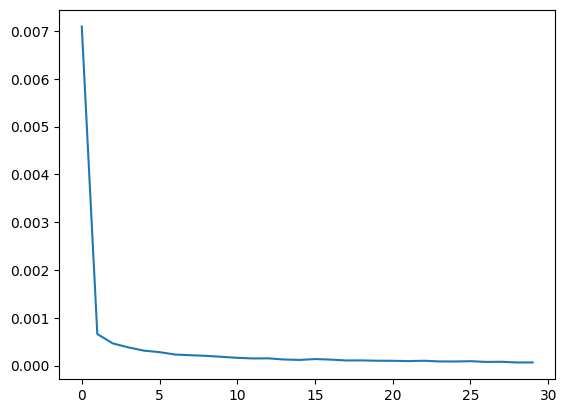

In [14]:
hist = pd.read_csv('train_hist.csv')
plt.plot(hist['mse'])

In [15]:
model = load_model("seq2seq_model_single")
model.summary()

2023-05-06 05:49:58.700458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-05-06 05:49:58.700561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-05-06 05:49:58.700630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           43600     
                                                                 
 lstm_1 (LSTM)               (None, 200)               240800    
                                                                 
 dense (Dense)               (None, 16)                3216      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 287,633
Trainable params: 287,633
Non-trainable params: 0
_________________________________________________________________


2023-05-06 05:50:00.547484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 05:50:00.549080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 05:50:00.550050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [18]:
# score, scores, actual, predicted = seq2seq_model.evaluate_model(model, train, test, 3, 60, features=range(8), features_out_num=1, initial_epochs=30, epochs=2, batches_to_train=1)
test_x, test_y = seq2seq_model.truncate_single_step(test, 60, features_in=range(8))
print(test_x.shape, test_y.shape)
results = model.evaluate(test_x, test_y)
preds = model.predict(test_x)

(2057, 60, 8) (2057, 1)


2023-05-06 05:50:24.091892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 05:50:24.093328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 05:50:24.094309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - 3s 37ms/step - loss: 4.9742e-05 - mae: 0.0044 - mse: 4.9742e-05


2023-05-06 05:50:27.204117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 05:50:27.205573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 05:50:27.206534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

65/65 [==============================] - 3s 36ms/step


RMSE:  0.007052816376071395
MAE:  0.004350046627223492


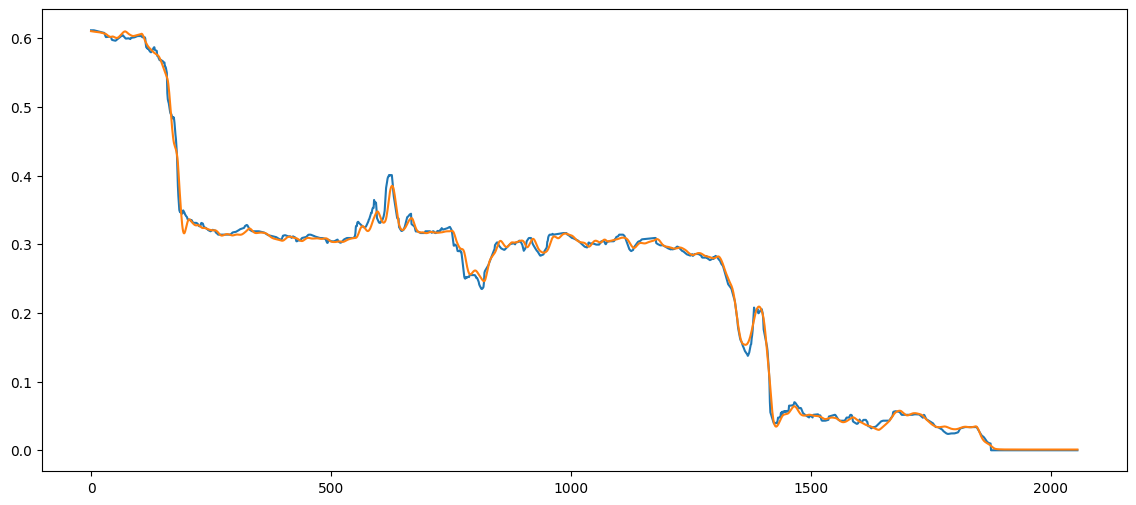

In [21]:
plt.figure(figsize=(14,6))
plt.plot(test_y[:,0])
plt.plot(preds)
print('RMSE: ', np.sqrt(results[0]))
print('MAE: ', results[1])

In [24]:
forecasts = []
for i in range(test.shape[0]):
    pred_x = test_x[60 * i, :, :]
    y_future = []
    for k in range(60):
        pred_y = model.predict(pred_x)
        y_future.append(pred_y)
        pred_x = np.append(pred_x[:, 1:, :], pred_y.reshape(1, 1, 8))
    forecasts.append(y_future)
    

In [ ]:
print('RMSE: ', score)
actual_odds = actual.reshape((actual.shape[0]*actual.shape[1]))
predicted_odds = predicted.reshape((predicted.shape[0]*predicted.shape[1]))
df_pred = pd.DataFrame({'pred':predicted_odds})
plt.figure(figsize=(14,6))
plt.plot(actual_odds)
for i in range(predicted.shape[0]):
    idx = 60 * i
    s_pred = df_pred.iloc[idx:idx + 60]
    plt.plot(s_pred, '--', color='red')

NameError: name 'score' is not defined